In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook
from scipy.linalg import svd

%matplotlib inline

## Подготовка данных

### "Схлопывание" повторяющихся действий пользователей

Для каждого пользователя посчитаем количество того, сколько раз он взаимодействовал с каждой категорией товара в данных транзакций.

In [33]:
path_transactions = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\transactions.csv"
path_clients = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\clients.csv"
path_categories = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\categories.csv"

In [3]:
transactions = pd.read_csv(path_transactions)
transactions.head()

,Unnamed: 0,client_id,product_category,product_company,subtype,amount,date,transaction_type
0,34478,37,29,NaN,Автоплатеж,1209,2020-01-01 00:00:00,Negative
1,65406,71,4,YouTube Music,Подписка,169,2020-01-01 00:00:00,Negative
2,82186,88,29,NaN,Автоплатеж,3711,2020-01-01 00:00:00,Negative
3,83113,89,29,NaN,Автоплатеж,6443,2020-01-01 00:00:00,Negative
4,131373,141,29,NaN,Автоплатеж,7319,2020-01-01 00:00:00,Negative


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929135 entries, 0 to 929134
Data columns (total 8 columns):
Unnamed: 0          929135 non-null int64
client_id           929135 non-null int64
product_category    929135 non-null int64
product_company     644651 non-null object
subtype             929135 non-null object
amount              929135 non-null int64
date                929135 non-null object
transaction_type    929135 non-null object
dtypes: int64(4), object(4)
memory usage: 56.7+ MB


In [5]:
transactions.product_category = transactions.product_category.astype('str')

In [6]:
transactions.date = pd.to_datetime(transactions.date)

In [7]:
transactions.dtypes

Unnamed: 0                   int64
client_id                    int64
product_category            object
product_company             object
subtype                     object
amount                       int64
date                datetime64[ns]
transaction_type            object
dtype: object

In [8]:
clients = pd.read_csv(path_clients)
clients.head()

,id,fullname,address,phone_number,email,workplace,birthdate,registration_date,gender,income,expenses,credit,deposit
0,1,Волкова Фаина Афанасьевна,"с. Новосибирск, наб. Привокзальная, д. 58 к. 5...",8 (475) 014-6494,wkirillov@rambler.ru,"ст. Кировск (Мурм.), ш. Коммуны, д. 238 стр. 3...",1966-09-07,2017-01-10,F,230910.0,61975,1.0,NaN
1,2,Пелагея Вячеславовна Галкина,"клх Белокуриха, ш. Комсомольское, д. 701 стр. ...",+7 (981) 576-1146,bogdanovmoke@rambler.ru,"г. Елабуга, бул. 60 лет Октября, д. 5, 070955",1987-05-23,2016-07-14,F,NaN,75232,NaN,NaN
2,3,Валентина Игоревна Фомина,"к. Усть-Катав, бул. Восточный, д. 292 стр. 3, ...",+7 (920) 068-58-36,mjasnikovvalentin@mail.ru,"г. Сосновый Бор, алл. Лесхозная, д. 146, 139446",1974-06-15,2017-10-18,F,NaN,88813,NaN,NaN
3,4,тов. Воронцова Фёкла Федоровна,"клх Новая Игирма, алл. Пограничная, д. 6/6, 73...",8 334 398 3828,martin85@rambler.ru,"клх Котельнич, бул. Серафимовича, д. 97, 753076",1979-10-19,2012-08-25,F,NaN,55167,NaN,NaN
4,5,Филипп Дмитриевич Воронцов,"к. Ребриха, пр. Свободы, д. 54, 466509",8 (296) 455-0453,jan_07@rambler.ru,"клх Карабудахкент, ул. Абрикосовая, д. 3 к. 19...",1986-08-14,2017-03-15,M,NaN,85106,NaN,NaN


In [34]:
categories = pd.read_csv(path_categories)
categories.head()

,id,name,description,mcc-code
0,1,Каршеринг,Краткосрочная аренда авто с оплатой по минутам...,"7512, 4121"
1,2,Супермаркеты,Покупки в супермаркетах и продуктовых магазинах,"5297, 5298, 5300, 5411, 5412, 5422, 5441, 5451..."
2,3,Такси,Услуги такси (каршеринг не входит в данную кат...,4121
3,4,Музыка,Покупки в магазинах музыки и музыкальных инстр...,"5733, 5735"
4,5,Фастфуд,Покупки в ресторанах быстрого питания,5814


In [9]:
transactions.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [10]:
clients_id = clients[['id']]
clients_id.head()

,id
0,1
1,2
2,3
3,4
4,5


In [11]:
transactions_part = transactions[['client_id', 'product_category', 'date']]
transactions_part.head()

,client_id,product_category,date
0,37,29,2020-01-01
1,71,4,2020-01-01
2,88,29,2020-01-01
3,89,29,2020-01-01
4,141,29,2020-01-01


In [12]:
data = transactions_part.groupby(['client_id', 'product_category'], as_index=False) \
    .agg({'date': 'count'}) \
    .rename(columns={'date': 'purchase_count'})

In [13]:
data.head()

,client_id,product_category,purchase_count
0,1,10,18
1,1,11,14
2,1,13,23
3,1,14,19
4,1,16,10


### Фильтрация неактивных пользователей

Отфильтруем пользователей, которые взаимодействовали не больше, чем с 4 категориями товаров и услуг.

In [14]:
users_interactions = data \
    .groupby('client_id', as_index=False) \
    .agg({'product_category': 'count'}) \
    .rename(columns={'product_category': 'unique_categories'})
users_interactions.head()

,client_id,unique_categories
0,1,18
1,2,21
2,3,24
3,4,21
4,5,19


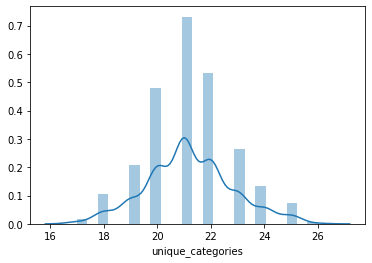

In [15]:
sns.distplot(users_interactions.unique_categories);

In [16]:
users_with_enough_interactions = users_interactions.query('unique_categories > 4')['client_id']
users_with_enough_interactions

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: client_id, Length: 1000, dtype: int64

In [17]:
print(f'Всего пользователей: {users_interactions.shape[0]}')
print(f'Пользователей по крайней мере с 5 взаимодействиями: {users_with_enough_interactions.shape[0]}')

Всего пользователей: 1000
Пользователей по крайней мере с 5 взаимодействиями: 1000


Получаем, что пользователей меньше, чем с 5 взаимодействиями нет.

### Нормализация

В качестве нормализации воспользуемся MinMaxScaler.

In [18]:
data = data.assign(purchase_normalize = (data.purchase_count - data.purchase_count.min()) / (data.purchase_count.max() - data.purchase_count.min()))
data.head()

,client_id,product_category,purchase_count,purchase_normalize
0,1,10,18,0.042607
1,1,11,14,0.032581
2,1,13,23,0.055138
3,1,14,19,0.045113
4,1,16,10,0.022556


### Разбиение выборки на тренировочную и тестовую

Произведем разбиение выборки на обучение и контроль по времени. Перед этим возьмем последнее время взаимодействия пары client_id и product_category.

In [19]:
transactions_last_date = transactions_part \
    .groupby(['client_id', 'product_category'], as_index=False) \
    .date \
    .last()
transactions_last_date.head()

,client_id,product_category,date
0,1,10,2020-12-22 02:33:13
1,1,11,2020-12-22 10:20:44
2,1,13,2020-12-29 09:07:06
3,1,14,2020-12-31 06:49:11
4,1,16,2020-12-29 03:38:07


In [20]:
data = data \
    .merge(transactions_last_date, on=['client_id', 'product_category']) \
    .rename(columns={'date': 'last_date'})
data.head()

,client_id,product_category,purchase_count,purchase_normalize,last_date
0,1,10,18,0.042607,2020-12-22 02:33:13
1,1,11,14,0.032581,2020-12-22 10:20:44
2,1,13,23,0.055138,2020-12-29 09:07:06
3,1,14,19,0.045113,2020-12-31 06:49:11
4,1,16,10,0.022556,2020-12-29 03:38:07


In [21]:
split_date = '2020-12-30'
data_train = data.query('last_date < @split_date').copy()
data_test = data.query('last_date >= @split_date').copy()

print(f'Всего взаимодействий: {data.shape[0]}')
print(f'Доля взаимодействий в тренировочной выборке: {round(data_train.shape[0] / data.shape[0], 1)} ({data_train.shape[0]})')
print(f'Доля взаимодействий в тестовой выборке: {round(data_test.shape[0] / data.shape[0], 1)} ({data_test.shape[0]})')

Всего взаимодействий: 21201
Доля взаимодействий в тренировочной выборке: 0.8 (17658)
Доля взаимодействий в тестовой выборке: 0.2 (3543)


Для удобства подсчета качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков

In [26]:
data_true = (
    data_train
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'product_category': 'true_train'})
    .set_index('client_id')
)

data_true['true_test'] = (
    data_test
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
)

Заполним пропуски пустыми списками.

In [27]:
data_true.loc[pd.isnull(data_true.true_test), 'true_test'] = [
    list() for x in range(len(data_true.loc[pd.isnull(data_true.true_test), 'true_test']))]

In [28]:
data_true.head(1)

,true_train,true_test
client_id,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]"


## Моделирование и оценка

Для каждого пользователя будем предсказывать только одну категорию товара или услуги в связи тем, что только реклама одной категории товара или услуги может быть показана пользователю в приложении.

В качестве метрик качества моделей будем использовать: precision@k, 

In [76]:
def calc_precision(column):
    return (
        data_true
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

### Baseline (модель по полуярности)

Посчитаем популярность каждой категории, как сумму всех количеств взаимодействия с ней, и отсортируем категории по их популярности.

In [42]:
top_k = 1 # количество категорий, которое нужно предсказать пользователю

In [32]:
popular_category = (
    data_train
    .groupby('product_category', as_index=False)
    .agg({'purchase_normalize': 'sum'})
    .rename(columns={'purchase_normalize': 'purchase_total'})
    .sort_values('purchase_total', ascending=False)
    .product_category.values
)
popular_category

array(['5', '28', '6', '2', '3', '1', '7', '11', '8', '13', '10', '14',
       '9', '15', '17', '21', '20', '16', '18', '19', '4', '29', '12',
       '26', '27', '24', '25', '22', '23'], dtype=object)

In [40]:
print(f"Наиболее популярной категорией является: {categories.query('id == @popular_category[0]')['name'].values[0]}")
print(f"Наименее популярной категорией является: {categories.query('id == @popular_category[-1]')['name'].values[0]}")

Наиболее популярной категорией является: Фастфуд
Наименее популярной категорией является: Автоуслуги


Делаем предсказания для каждого пользователя.

#### Без учета того, что пользователь уже приобретал

В этом случае мы будем пользователю также рекомендовать те категории товаров и услуг, которые он приобретал. В этом случае каждому пользователю предлагаем самую популярную категорию.

In [64]:
data_true['prediction_popular_without'] = np.resize(popular_category[:top_k], (data_true.shape[0], 1))

In [65]:
data_true.head()

,true_train,true_test,prediction_popular_without
client_id,,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]",5
2,"[1, 10, 11, 13, 14, 15, 16, 17, 18, 19, 2, 20,...",[5],5
3,"[10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 2...","[1, 14, 2, 5, 6, 9]",5
4,"[10, 13, 14, 16, 17, 18, 19, 2, 20, 21, 23, 24...","[11, 28, 6, 9]",5
5,"[1, 11, 13, 14, 16, 17, 18, 19, 2, 20, 21, 28,...","[10, 6]",5


In [77]:
calc_precision('prediction_popular_without')

0.14890538174745013

#### С учетом того, что пользователь уже приобретал

Теперь рассмотрим вариант, когда рекомендуем пользователю только те категории, которые он еще не приобретал.

In [73]:
data_true['prediction_popular_with'] = (
    data_true.true_train
    .apply(
        lambda x:
        popular_category[~np.in1d(popular_category, x)][:top_k]
    )
)

In [74]:
data_true.head()

,true_train,true_test,prediction_popular_without,prediction_popular_with
client_id,,,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]",5,[5]
2,"[1, 10, 11, 13, 14, 15, 16, 17, 18, 19, 2, 20,...",[5],5,[5]
3,"[10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 2...","[1, 14, 2, 5, 6, 9]",5,[5]
4,"[10, 13, 14, 16, 17, 18, 19, 2, 20, 21, 23, 24...","[11, 28, 6, 9]",5,[28]
5,"[1, 11, 13, 14, 16, 17, 18, 19, 2, 20, 21, 28,...","[10, 6]",5,[6]


In [75]:
calc_precision('prediction_popular_with')

0.33836705930191663

### Коллаборативная фильтрация

In [78]:
data_matrix = pd.pivot_table(data, index='client_id', columns='product_category', values='purchase_normalize', fill_value=0)
data_matrix.head()

product_category,1,10,11,12,13,14,15,16,17,18,...,27,28,29,3,4,5,6,7,8,9
client_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.042607,0.032581,0.0,0.055138,0.045113,0.000000,0.022556,0.012531,0.040100,...,0.0,0.275689,0.000000,0.000000,0.027569,0.378446,0.974937,0.065163,0.060150,0.047619
2,0.072682,0.050125,0.045113,0.0,0.045113,0.042607,0.107769,0.020050,0.025063,0.017544,...,0.0,0.298246,0.000000,0.100251,0.010025,0.338346,0.756892,0.030075,0.032581,0.062657
3,0.095238,0.037594,0.062657,0.0,0.040100,0.040100,0.105263,0.017544,0.022556,0.017544,...,0.0,0.295739,0.000000,0.090226,0.027569,0.395990,0.769424,0.072682,0.042607,0.052632
4,0.000000,0.047619,0.040100,0.0,0.025063,0.035088,0.000000,0.020050,0.005013,0.040100,...,0.0,0.248120,0.027569,0.000000,0.012531,0.293233,0.927318,0.042607,0.067669,0.050125
5,0.110276,0.082707,0.057644,0.0,0.062657,0.070175,0.000000,0.015038,0.025063,0.025063,...,0.0,0.255639,0.000000,0.107769,0.000000,0.385965,0.979950,0.067669,0.052632,0.065163


#### Memory-dased

In [79]:
matrix = data_matrix.values

In [84]:
similarity_users = np.zeros((len(matrix), len(matrix)))

for i in tqdm_notebook(range(len(matrix)-1)):
    for j in range(i+1, len(matrix)):
        
        # nonzero elements of two users
        mask_uv = (matrix[i] != 0) & (matrix[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = matrix[i, mask_uv]
        ratings_u = matrix[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

In [85]:
prediction_user_based = []
for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(matrix[users_sim].sum(axis=0))[::-1]
        tmp_recommend = data_matrix.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, data_true.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

data_true['prediction_user_based'] = prediction_user_based

C:\Users\kiril\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [86]:
calc_precision('prediction_user_based')

0.5111497857838353

#### Latent Factor Model

In [93]:
U, sigma, V = svd(data_matrix)
print(data_matrix.shape, U.shape, sigma.shape, V.shape)

(1000, 29) (1000, 1000) (29,) (29, 29)


In [94]:
Sigma = np.zeros((1000, 29))
Sigma[:29, :29] = np.diag(sigma)

new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))

6.385793947506476e-26


In [95]:
K = 25
sigma[K:] = 0
Sigma = np.zeros((1000, 29))
Sigma[:29, :29] = np.diag(sigma)

In [96]:
new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))
print(sum(sum((data_matrix.values.mean() - data_matrix.values) ** 2)))

0.0005187998118375348
809.8458534297037


In [97]:
new_data_matrix = pd.DataFrame(new_data_matrix, index=data_matrix.index, columns=data_matrix.columns)

predictions = []
for client_id in tqdm_notebook(data_true.index):
    prediction = (
        new_data_matrix
        .loc[client_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            data_true.loc[client_id, 'true_train'])])[:top_k])

data_true['prediction_svd'] = predictions

In [98]:
calc_precision('prediction_svd')

0.3416977838090405

### Контентная модель

### Факторизационная машина